# Holography reconstruction

## Import modules
Note hyperspy is only used as a convenient/reliable way of loading a range of microscope output files, alternatives could be used such as dm3_reader

In [3]:
import hyperspy.api as hs
from matplotlib import pyplot as plt
import numpy as np
from scipy import constants 
from skimage.restoration import unwrap_phase
from scipy import ndimage



%matplotlib qt

In [15]:
## Load holograms
#file_ob should be the object hologram and file_ref should be the reference hologram file name

# Load object and reference files

# folder = r'4_3_20_magnetite_tubes/'
# file_ob = r'004_1300x_hol.dm3'
# file_ref = r'004_1300x_ref.dm3'
# file_ob = r'013_1300x_a_-25deg_hol.dm3'
# file_ref = r'013_1300x_a_-25deg_ref.dm3'

# Maghemite rings
folder = r'C:\Users\grl31\OneDrive - University Of Cambridge\Cambridge\Mini 1\Holography data/'
#folder = r'/home/grl31/Dropbox (Cambridge University)/Linux-Surface share/Holography/Maghemite rings/'
file_ob = r'019_hol.dm3'
file_ref = r'019_ref.dm3'

# Magnetite tubes
# folder = r'C:\Users\grl31\Dropbox (Cambridge University)\Linux-Surface share\Holography\4_3_20_magnetite_tubes/'
# file_ob = r'004_1300x_hol.dm3'
# file_ref = r'004_1300x_ref.dm3'


ob = hs.load(folder + file_ob).data
ref= hs.load(folder + file_ref).data

%matplotlib qt
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(np.log10(abs(ob)))
axs[1].imshow(np.log10(abs(ref)))
axs[0].set_title('Object')
axs[1].set_title('Reference')
axs[0].axis('off')
axs[1].axis('off')

(-0.5, 2047.5, 2047.5, -0.5)

## Apply Hamming window
- This is to remove the zero-frequency component 'cross' that occurs due to the square pixel array of the camera

In [6]:
# create window
size = np.shape(ob)[0]
ham1d = np.hamming(size)
ham2d = (np.outer(ham1d,ham1d))**1 # 0.5 normalises but might not remove cross

# apply window
ob = ham2d*ob
ref = ham2d*ref

# view data
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(np.log10(abs(ob)))
axs[1].imshow(np.log10(abs(ref)))
axs[0].set_title('Object')
axs[1].set_title('Reference')
axs[0].axis('off')
axs[1].axis('off')

(-0.5, 2047.5, 2047.5, -0.5)

## Apply Fourier transforms

In [7]:
%matplotlib qt
%matplotlib qt

# fftshift shifts the zero-frequency to the centre of the spectrum
ob_ft = np.fft.fft2(ob)
ob_ft = np.fft.fftshift(ob_ft)
ref_ft = np.fft.fft2(ref)
ref_ft = np.fft.fftshift(ref_ft)

# Can only view the absolute of the fourier transform as it can't handle the imaginary components
# using a log10 scale helps improve contrast

fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(np.log10(abs(ob_ft)))
axs[1].imshow(np.log10(abs(ref_ft)))
axs[0].set_title('Object FT')
axs[1].set_title('Reference FT')

Text(0.5, 1.0, 'Reference FT')

## Select only the sideband using a mask
- input the coordinates of the sideband centre (fxc,fyc) and radius (rc) in pixels

In [10]:
%matplotlib qt
# centre of sideband in fourier space - inspect reference hologram if doing manually
fxc, fyc = 1016,913 #1007,866
# radius of sideband
rc = 16 # trade off phase contrast for spatial resolution as radius increases

# create mask
def create_circular_mask(imsize, center=(None), radius=None):
    h,w = imsize,imsize
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    mask = np.ones((h,w))
    mask[dist_from_center >= radius] = 0
    #mask = dist_from_center <= radius
    
    # blur edge of mask
    mask = abs(ndimage.gaussian_filter(mask, sigma=1))
    
    return mask

circ_mask = create_circular_mask(size,center=[fxc,fyc],radius=rc)

def apply_circular_mask(circ_mask,im_ft):
    masked_im = im_ft.copy()
    masked_im = masked_im*circ_mask
    #masked_im[~circ_mask] = 0
    return masked_im

masked_ob = apply_circular_mask(circ_mask,ob_ft)
masked_ref = apply_circular_mask(circ_mask,ref_ft)


fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(np.log10(abs(ob_ft)))
axs[0].imshow(np.log10(abs(masked_ob)), cmap='Oranges_r',alpha=0.9)
axs[1].imshow(np.log10(abs(ref_ft)))
axs[1].imshow(np.log10(abs(masked_ref)), cmap='Oranges_r',alpha=0.9)
axs[0].set_title('Masked object sideband', color = 'orange')
axs[1].set_title('Masked reference sideband', color= 'orange')

C:\Users\grl31\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10
C:\Users\grl31\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.0, 'Masked reference sideband')

In [219]:
# auto-find centre
maxval = np.amax(masked_ob)
maxind = np.where(masked_ob == maxval)
fxc,fyc = maxind[1][0], maxind[0][0]


# auto-find radius
dx = size/2 - fxc
dy = size/2 - fyc
rc = (dx**2 + dy**2)**0.5 / 2 - 10

# remask
circ_mask = create_circular_mask(size,center=[fxc,fyc],radius=rc)
masked_ob = apply_circular_mask(circ_mask,ob_ft)
masked_ref = apply_circular_mask(circ_mask,ref_ft)
plt.imshow(np.log10(abs(ob_ft)))
plt.imshow(np.log10(abs(masked_ob)),cmap='Blues_r')

/home/grl31/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


In [120]:
# Get amplitude image
circ_mask = create_circular_mask(size,radius=rc*2)
amp_ob_masked = apply_circular_mask(circ_mask,ob_ft)
amp_ref_masked = apply_circular_mask(circ_mask,ref_ft) # mask out all but central sideband
amp_ob = np.fft.ifft2(amp_ob_masked)
amp_ref = np.fft.ifft2(amp_ref_masked)

fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(np.log10(abs(ob_ft)))
axs[0].imshow(np.log10(abs(amp_ob_masked)), cmap='Greens_r',alpha=0.9)
axs[1].imshow(abs(amp_ob))
axs[0].set_title('Masked Object central peak', color = 'green')
axs[1].set_title('Amplitude image')

/home/grl31/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Amplitude image')

## Shift sideband to centre

In [11]:
%matplotlib qt
def centre_sideband(masked_im,fxc,fyc,rc):
    """ Centre by cropping around sideband centre then padding back out with zeros """
    cropped_im = masked_im[fyc-2*rc:fyc+2*rc,fxc-2*rc:fxc+2*rc]
    size_cropped = np.shape(cropped_im)[0]
    size_pad = size-size_cropped
    centred_im = np.pad(cropped_im,int(size_pad/2),mode='constant')
    return centred_im

centred_ob = centre_sideband(masked_ob,fxc,fyc,rc)
centred_ref = centre_sideband(masked_ref,fxc,fyc,rc)

fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(np.log10(abs(centred_ob)))
axs[1].imshow(np.log10(abs(centred_ref)))
axs[0].set_title('Centred Object sideband')
axs[1].set_title('Centred Reference sideband')

C:\Users\grl31\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\grl31\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Centred Reference sideband')

In [52]:
#slower method

# def centre_sideband(masked_im, fxc,fyc):
#     trans = np.zeros_like(masked_im)
#     for x in range(size):
#         for y in range(size):
#             try:
#                 trans[x][y] = masked_im[y - int(size/2 - fyc)][x - int(size/2 - fxc)]
#             except:
#                 trans[x][y] = 0
#     return trans
       
# centred_ob = centre_sideband(masked_ob,fxc,fyc)
# centred_ref = centre_sideband(masked_ref,fxc,fyc)

In [242]:
plt.imshow(np.log10(abs(np.fft.ifft2(ob))))

## Calculate phase shift

In [12]:
def extract_wf_and_phase(ob,ref):

    extracted_ob = np.fft.ifft2(ob)
    extracted_ref = np.fft.ifft2(ref)

    psi_0 = extracted_ob / extracted_ref
    phase = np.arctan2(np.imag(psi_0),np.real(psi_0)) # or np.angle(psi_0)

    return psi_0, phase

psi_0, phase = extract_wf_and_phase(centred_ob,centred_ref)
#plt.imshow(phase)  
#plt.colorbar()

fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(phase)
axs[1].imshow(np.log10(abs(psi_0)))
axs[0].set_title('Overall phase-shift')
axs[1].set_title('$\psi_0$')

Text(0.5, 1.0, '$\\psi_0$')

In [16]:
# phase unwrap
%matplotlib qt
pu = unwrap_phase(phase)
pu = pu+abs(np.min(pu))
plt.imshow(pu)
plt.colorbar()
plt.title('Overall phase shift $Unwrapped$')

Text(0.5, 1.0, 'Overall phase shift $Unwrapped$')

## Plot cosine of phase shift

In [14]:
cos_phase = np.cos(pu*10)

plt.imshow(cos_phase)
plt.title('cos( pa * phase )')

Text(0.5, 1.0, 'cos( pa * phase )')

## Calculate B field

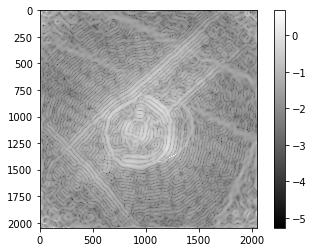

In [150]:
# Calculate from unwrapped phase

d_phase = np.gradient(-(-pu-25*phi_e))
z_size = 60
b_const = 1#(constants.codata.value('mag. flux quantum')/(constants.nano**2))/(np.pi*z_size)
b_field_x = -b_const*d_phase[0]#/y_res
b_field_y = b_const*d_phase[1]#/x_res

# calculate directly from wavefunction
# d_wf = np.imag(np.gradient(psi_0))
# b_const = 1
# b_field_x = -b_const*d_wf[0]#/y_res
# b_field_y = b_const*d_wf[1]#/x_res

mag_B = np.hypot(b_field_x,b_field_y)
plt.imshow(np.log10(mag_B))
plt.colorbar()

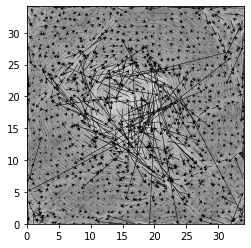

In [151]:
s=60
plt.imshow(np.log10(mag_B),extent=[0,size/s,0,size/s],origin='lower')
plt.quiver(b_field_x[::s, ::s],b_field_y[::s, ::s],
           headwidth=8,linewidth=1.5,headlength=7,scale=1)

## Calculate sample thickness from amplitude

In [66]:
# calculate mfp Cheng, Egerton 1988
E0 = 112 # accelerating voltage kv
beta = 5.6 # collection angle in mrad

# Relativistic factor
F = (1+(E0/1022))/(1+(E0/511))**2

# Effective atomic number
zeff = (3/7*26**1.3 + 4/7*8**1.3) / (3/7*26**0.3 + 4/7*8**0.3)

# Mean energy loss
Em = 7.6 * zeff**0.36

# mean free path
mfp = 106*F*E0 / (Em * np.log(2*beta*E0/Em))
mfp

102.42457227761932

In [69]:
# calculate amplitude and reference
%matplotlib qt
%matplotlib qt
extracted_ob = np.fft.ifft2(centred_ob)
extracted_ref = np.fft.ifft2(centred_ref)
psi_0 = extracted_ob / extracted_ref
A = np.abs(psi_0)
t = -np.log(A)*2*mfp
#t[t<0] = 0
x,y = np.gradient(t)
plt.imshow(t)
plt.colorbar()

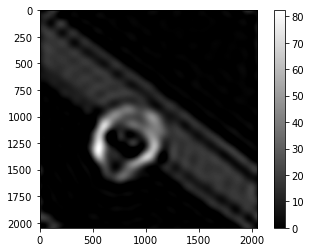

In [126]:

def calculate_thickness(amp_ob,amp_ref,mfp):
    #mfp = 70centred_obree path in nm
    # Beer-Lambert A = e^(-t/2λ)
    A = abs((amp_ob/amp_ref))
    t = -np.log(A)*2*mfp
    #t = t*ham2d
    
    t[t<0] = 0
    return t

t = calculate_thickness(amp_ob,amp_ref,mfp)
plt.imshow(t)
plt.colorbar()

## Calculate electrostatic phase from thickness

In [70]:
f_Fe2 = 2.802
f_Fe3 = 2.298 
f_O2 = 4.0992

sum_nf = (1*f_Fe2 + 2*f_Fe3 + 4*f_O2)*8

a = 0.839 # unit cell parameter in nm
omega = (a*10)**3 # volume of unit cell in A^3
V0 = 47.88 * sum_nf / omega

def λ_func(V):
    V *= constants.kilo
    λ = constants.h/(constants.nano*np.sqrt(2*V*constants.m_e*constants.e))
    λ *= 1/(np.sqrt(1+(constants.e*V)/(2*constants.m_e*constants.c**2)))
    return λ

kv = 112
e = constants.e
λ = λ_func(kv) * 1e-9
E = kv*1000*e
CE = np.pi * e / (λ*E)

phi_e_unsmoothed = CE*V0*t*10**-9
plt.imshow(phi_e_unsmoothed)
plt.colorbar()
print(V0)

15.432642829327676


## Smooth electrostatic phase

In [71]:
from scipy import ndimage
phi_e = ndimage.gaussian_filter(phi_e_unsmoothed, sigma=0)
plt.imshow(phi_e)
plt.colorbar()

In [130]:
# calculate corrected phase
%matplotlib qt
def phase_correcter(pu, phi_e, x):
    return pu+abs(np.min(pu))-x*phi_e

phi_B = phase_correcter(pu,phi_e,0.1)
plt.imshow(phi_B)
plt.colorbar()

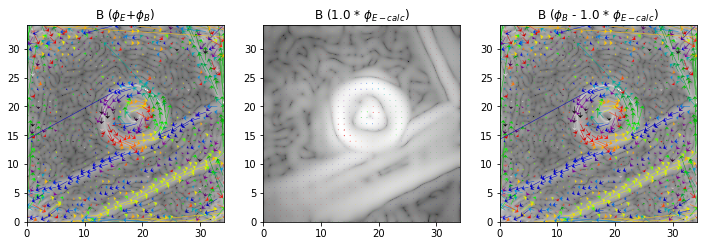

In [178]:
def B_plotter(pu, phi_e,x):
    phi_B = phase_correcter(pu,phi_e,x)
    
    fig, axs = plt.subplots(ncols=3,figsize=(12,12))
    
    for i,phi in enumerate([pu, phi_e*x, phi_B]):
        d_phase = np.gradient(-phi)
        #z_size = 60
        b_const = 1#(constants.codata.value('mag. flux quantum')/(constants.nano**2))/(np.pi*z_size)
        b_field_x = -b_const*d_phase[0]#/y_res
        b_field_y = b_const*d_phase[1]#/x_res

        # calculate directly from wavefunction
        # d_wf = np.imag(np.gradient(psi_0))
        # b_const = 1
        # b_field_x = -b_const*d_wf[0]#/y_res
        # b_field_y = b_const*d_wf[1]#/x_res

        mag_B = np.hypot(b_field_x,b_field_y)

        s=60
        axs[i].imshow(np.log10(mag_B),extent=[0,size/s,0,size/s],origin='lower')
        axs[i].quiver(b_field_x[::s, ::s],b_field_y[::s, ::s], np.arctan2(b_field_x[::s, ::s],b_field_y[::s, ::s]),
                   headwidth=12,linewidth=3,headlength=7,scale=0.5,cmap='nipy_spectral')
        
        if i == 0:
            axs[i].set_title('B ($\phi_E$+$\phi_B$)')
        if i ==1:
            axs[i].set_title('B (%.1f * $\phi_{E-calc})$' % x)
        if i ==2:
            axs[i].set_title('B ($\phi_B$ - %.1f * $\phi_{E-calc})$' % x)

    
    
B_plotter(pu,phi_e,1)

In [46]:
import matplotlib.colors
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches

cvals  = [-2., 2]
colors = ["black","black"]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[int(0.05*cmap.N):int(0.85*cmap.N),-1] = np.linspace(.95, 0, 0.8*cmap.N+1)
my_cmap[int(0.85*cmap.N):,-1] = np.ones_like(my_cmap[int(0.85*cmap.N):,-1])*0
# Create new colormap
my_cmap = ListedColormap(my_cmap)

# Function for later
def cart2pol(x, y):
    """ Convert cartesian to polar coordinates
    rho = magnitude, phi = angle """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def rafal_plotter(phi,t,ax,title='B'):
    d_phase = np.gradient(-phi)
    b_const = 1#(constants.codata.value('mag. flux quantum')/(t*constants.nano**2))
    b_field_x = -b_const*d_phase[0]#/y_res
    b_field_y = b_const*d_phase[1]#/x_res
    mag_B = np.hypot(b_field_x,b_field_y)
    cos_phase = np.cos(phi*20)
    
    # plot B field direction as a colour
    ax.imshow(np.arctan2(b_field_y,b_field_x),origin='lower', cmap='hsv_r')
    
    
    
    # Plot cosine of phase as black/transparent
    ax.imshow(cos_phase,origin='lower', cmap=my_cmap)
    
    # Plot magnitude of B as in black/transparent scale
    cb = ax.imshow(mag_B,origin='lower', cmap=my_cmap, vmin=0)
    
    #fig.colorbar(cb,ax=ax,fraction=0.046, pad=0.04)
    ax.set_title(title)
    plt.tight_layout()

In [72]:
%matplotlib qt
%matplotlib qt
%matplotlib qt

fig, axs = plt.subplots(ncols=4,nrows=2,figsize=(20,12))

pu_smooth = ndimage.gaussian_filter(pu, sigma=0)

rafal_plotter(pu_smooth,t,axs[0,0],title='B (from raw)')
param = .08
rafal_plotter(param*phi_e,t,axs[0,1],title='B (from .8$\phi_e$)')
rafal_plotter(pu_smooth-param*phi_e,t,axs[0,2],title='B (from raw-.8$\phi_e$)')

# Create coordinate space
x = np.linspace(-1,1,200)
y = x
X,Y = np.meshgrid(x,y)

# Map theta values onto coordinate space 
thetas = np.ones_like(X)*0
for ix, xx in enumerate(x):
    for iy, yy in enumerate(y):
        thetas[ix,iy] = cart2pol(xx,yy)[1]

# Plot hsv colormap of angles
im1 = axs[0,3].imshow(thetas,cmap='hsv_r')
im1 = axs[1,3].imshow(thetas,cmap='hsv_r')

def B_plotter(phi,ax):
    
    fig, axs = plt.subplots(ncols=3,figsize=(12,12))
    
    d_phase = np.gradient(-phi)
    #z_size = 60
    b_const = 1#(constants.codata.value('mag. flux quantum')/(constants.nano**2))/(np.pi*z_size)
    b_field_x = -b_const*d_phase[0]#/y_res
    b_field_y = b_const*d_phase[1]#/x_res

    # calculate directly from wavefunction
    # d_wf = np.imag(np.gradient(psi_0))
    # b_const = 1
    # b_field_x = -b_const*d_wf[0]#/y_res
    # b_field_y = b_const*d_wf[1]#/x_res

    mag_B = np.hypot(b_field_x,b_field_y)

    s=60
    ax.imshow(np.log10(mag_B),extent=[0,size/s,0,size/s],origin='lower')
    ax.quiver(b_field_x[::s, ::s],b_field_y[::s, ::s], np.arctan2(b_field_y[::s, ::s],b_field_x[::s, ::s]),
               headwidth=12,linewidth=3,headlength=7,scale=0.3,cmap='hsv_r')

#     if i == 0:
#         axs[i].set_title('B ($\phi_E$+$\phi_B$)')
#     if i ==1:
#         axs[i].set_title('B (%.1f * $\phi_{E-calc})$' % x)
#     if i ==2:
#         axs[i].set_title('B ($\phi_B$ - %.1f * $\phi_{E-calc})$' % x)

    
    
B_plotter(pu_smooth,axs[1,0])
B_plotter(param*phi_e,axs[1,1])
B_plotter(pu_smooth-param*phi_e,axs[1,2])

In [95]:
def create_circular_mask(imsize, center=(None), radius=None):
    h,w = imsize,imsize
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    mask = np.ones((h,w))
    mask[dist_from_center >= radius] = 0
    #mask = dist_from_center <= radius
    
    # blur edge of mask
    mask = abs(ndimage.gaussian_filter(mask, sigma=1))
    
    return mask

circ_mask = create_circular_mask(size,center=[925,1032],radius=400)

def apply_circular_mask(circ_mask,im_ft):
    masked_im = im_ft.copy()
    masked_im = masked_im*circ_mask
    #masked_im[~circ_mask] = 0
    return masked_im

pu_masked = apply_circular_mask(circ_mask,pu)
import copy
mask = copy.deepcopy(t)
#mask[mask<30] = 0
mask[mask>230] = 4.8
mask[mask!=0] = 1
pu_masked=pu_masked*mask
plt.imshow(pu_masked)

In [112]:
%matplotlib qt
%matplotlib qt



d_phase = np.gradient(-phase) # np.imag(np.gradient(psi_0))
b_const = 1#(constants.codata.value('mag. flux quantum')/(t*constants.nano**2))
b_field_x = -b_const*d_phase[0]#/y_res
b_field_y = b_const*d_phase[1]#/x_res
dir_B = np.arctan2(b_field_y,b_field_x)
mag_B = np.hypot(b_field_x,b_field_y)



#plt.imshow(mask)
n = np.shape(mask)[0]
s=70
#cos = np.cos(pu_masked*mask*30)
#plt.imshow(mask)
plt.imshow(dir_B*mask, vmax=0.01,cmap='hsv_r',origin='lower',extent=[0,n/s,0,n/s])
plt.imshow(mag_B*mask, vmax=0.01,cmap=my_cmap,origin='lower',extent=[0,n/s,0,n/s])
plt.imshow(cos,cmap=my_cmap,origin='lower',extent=[0,n/s,0,n/s])
plt.quiver(b_field_x[::s, ::s]*mask[::s, ::s],b_field_y[::s, ::s]*mask[::s, ::s], np.arctan2(b_field_y[::s, ::s],b_field_x[::s, ::s])*mask[::s, ::s],
              headwidth=12,linewidth=3,headlength=7,scale=0.2,cmap='hsv_r',pivot='mid')
plt.colorbar()


In [111]:

phi_e[phi_e>np.max(pu)] = np.max(pu)
phi_e[phi_e<0] = 0
plt.imshow(np.cos(1*(pu-phi_e)))

phase = pu-phi_e

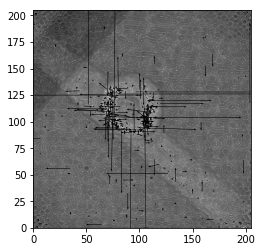

In [63]:
skip_arrow=10
plt.imshow(np.log10(1/B),extent=[0,size/10,0,size/10],origin='lower')
plt.quiver(1/b_field_x[::skip_arrow, ::skip_arrow],1/b_field_y[::skip_arrow, ::skip_arrow],scale=1e7)

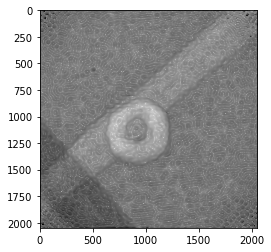

In [64]:
plt.imshow(np.log10(2/B))

In [239]:
# try to remove contribution from thickness
t = (-2*np.log(abs(amp_ob)/abs(amp_ref))).T

plt.imshow(np.cos((pu-10*t)*3))